In [362]:
# Sources : 

# Effective Federal Funds Rate (EFFR)
# https://www.newyorkfed.org/markets/reference-rates/effr

# Target Range of the Federal Funds Rate (FFTR)
# https://www.federalreserve.gov/economy-at-a-glance-policy-rate.htm

# TBOND
# https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025

# ARIMA model
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [363]:
pip install --upgrade git+https://github.com/Matteo-Bernard/EcoWatch.git

  Cloning https://github.com/Matteo-Bernard/EcoWatch.git to c:\users\matteo\appdata\local\temp\pip-req-build-yefm_s21
  Resolved https://github.com/Matteo-Bernard/EcoWatch.git to commit 060c477cea035d31a41ee14917f4574562866426
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/Matteo-Bernard/EcoWatch.git 'C:\Users\Matteo\AppData\Local\Temp\pip-req-build-yefm_s21'


### Scraping endogène and inendogène datas

In [ ]:
from EcoWatch.Scraping import tbond, fedfunds
import numpy as np

# Get the EFFR dataset
effr = fedfunds(ticker='EFFR', start='2000-01-01', end='2025-01-01')['Rate (%)']
effr = effr.resample('W').last()
effr.name = 'effr'

# Get the US Treasury Bonds dataset
tbonds = tbond('2000', '2025')
tbonds = tbonds.drop(['20 Yr', '30 Yr', '1.5 Month'], axis=1) # Drop unrelevant maturities
tbonds = tbonds.interpolate(axis=1) # Interpolate missing values
tbonds = tbonds.dropna(axis=0)
tbonds = tbonds.resample('W').last()

# Define the maturities of the US Treasury Bonds
maturities = np.unique([
    int(col.split()[0]) / 12 if "Mo" in col else int(col.split()[0])
    for col in tbonds.columns
])

### Feature Engineering

In [ ]:
from EcoWatch.NelsonSiegelCurvature import NSC

# Define parameter bounds for optimization: 
bounds = [(0, 1), (-1, 1), (-1, 1), (0, 5)] # Intercept (β0), Slope (β1), Curvature (β2), and Lambda (λ)
x0 = [0.01, 0.01, 0.01, 0.5] # Initial guess for the optimization algorithm
method = 'SLSQP' # Optimization method used for minimization

# Create an instance of the Nelson-Siegel-Curvature class
NelsonSiegelCurvature = NSC(maturities=maturities, bounds=bounds, x0=x0, method=method)

# Adjust Nelson-Siegel parameters for the curve
nsc = NelsonSiegelCurvature.fit(yields=tbonds)

Fitting Nelson-Siegel: 1237it [00:02, 544.11it/s]


In [368]:
# Display the EFFR dataset description
print("EFFR description")
print("==============================================================================")
print(effr.describe().round(2).to_string()) 
print("\n")

# Display the US Treasury Bonds dataset description
print("US Treasury bonds description")
print("==============================================================================")
print(tbonds.describe().round(2).to_string()) 
print("\n")

# Display the Nelson-Siegel-Curvature dataset description
print("Neslon Siegel Parameters description")
print("==============================================================================")
print(nsc.describe().round(6).to_string()) 

EFFR description
count    1279.00
mean        1.83
std         1.95
min         0.04
25%         0.13
50%         1.16
75%         3.08
max         6.60


US Treasury bonds description
          1 Mo     2 Mo     3 Mo     4 Mo     6 Mo     1 Yr     2 Yr     3 Yr     5 Yr     7 Yr    10 Yr
count  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00  1237.00
mean      1.58     1.62     1.64     1.70     1.74     1.82     2.00     2.18     2.55     2.86     3.13
std       1.80     1.81     1.82     1.82     1.81     1.73     1.58     1.47     1.32     1.23     1.17
min       0.00     0.00     0.00     0.02     0.02     0.04     0.09     0.11     0.21     0.39     0.55
25%       0.07     0.08     0.09     0.12     0.15     0.25     0.59     0.92     1.50     1.89     2.15
50%       0.93     0.96     0.99     1.08     1.13     1.30     1.60     1.79     2.42     2.82     3.07
75%       2.41     2.44     2.44     2.49     2.66     2.83     3.20     3.48   

In [ ]:
import pandas as pd

data = pd.concat([effr.shift(-1), nsc[['Intercept', 'Slope', 'Curvature', 'Lambda']]], axis=1).dropna()

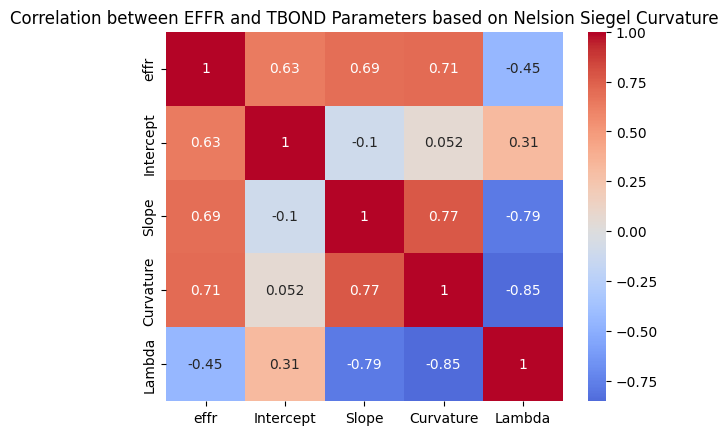

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between EFFR and TBOND Parameters based on Nelsion Siegel Curvature')
plt.show()

### Analyse des ordres de la série endogène (EFFR) (ADF, ACF, PACF)

ADF Statistic: -3.4165
p-value: 0.0104
Critical Values:
   1% : -3.4356
   5% : -2.8638
   10% : -2.568


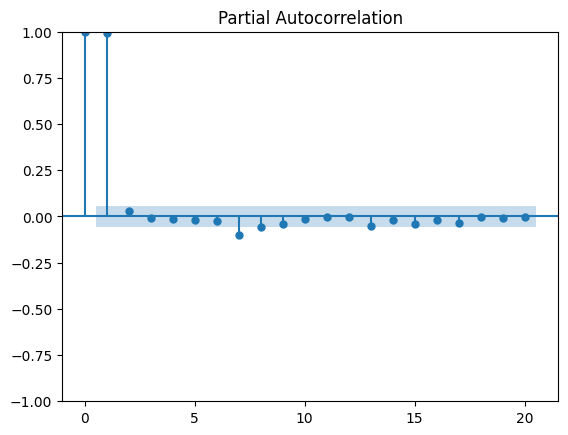

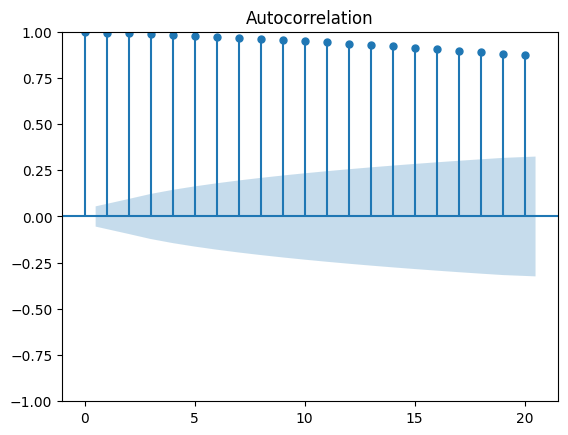

In [371]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

result = adfuller(effr)
print(f"ADF Statistic: {round(result[0], 4)}")
print(f"p-value: {round(result[1], 4)}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {round(value, 4)}")

plot_pacf(effr, lags=20)
plot_acf(effr, lags=20)
plt.show()

**Test ADF (Augmented Dickey-Fuller)**  
La statistique ADF est inférieure au seuil de 5% mais supérieure au seuil de 1%, ce qui signifie que :  
- Nous rejetons l’hypothèse nulle de racine unitaire au seuil de 5 %    
- La série est stationnaire au sens faible  
Il n’est pas nécessaire de différencier la série pour l’estimation du modèle ARIMAX, nous prenons d = 0

**ACF (Autocorrelation Function)**  
Observation :   
- L’autocorrélation est forte et persistante jusqu’au lag 20    
- Le déclin est lent, ce qui signale une structure fortement autorégressive 
Interprétation :    
- Ce comportement est typique d’un processus AR (Auto-Régressif) de haut ordre  
- Il n’y a pas de pic significatif unique, nous prenons q = 0

**PACF (Partial Autocorrelation Function)** 
Observation :   
- Des pics nets et significatifs aux lags 1 et 2, suivis d’une chute brutale et d’un bruit faible autour de zéro    
Interprétation :    
- Ce profil correspond classiquement à un processus AR(2)   
- La décroissance nette après le lag 2, nous prenons p = 2  

### Construction du modèle ARIMAX
#### 1. Sélection des variables exogènes

In [372]:
from statsmodels.tsa.arima.model import ARIMA

arimax = ARIMA(
    endog=data['effr'], # Variable endogène
    exog=data[['Intercept', 'Slope', 'Curvature', 'Lambda']], # Variables exogènes
    order=(2, 0, 0), # modèle ARIMA d'ordre (p, d, q)
    trend='n', # Ne pas ajouter de tendance
)
arimax_fit = arimax.fit()
print(arimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   effr   No. Observations:                 1222
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 947.119
Date:                Fri, 11 Apr 2025   AIC                          -1880.238
Time:                        18:07:47   BIC                          -1844.480
Sample:                    08-05-2001   HQIC                         -1866.780
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     91.3270      1.696     53.834      0.000      88.002      94.652
Slope         58.2589      1.018     57.227      0.000      56.264      60.254
Curvature     18.7445      0.681     27.507      0.0

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Variables retenues : Intercept, Slope, Curvature**    
Les trois premières composantes présentent des résultats statistiques robustes :    
- p-values très inférieures à 1 %, ce qui permet de rejeter sans ambiguïté l’hypothèse nulle selon laquelle leur coefficient serait nul 
- Statistiques z élevées, confirmant une forte significativité statistique  
- Intervals de confiance resserrés et éloignés de zéro, traduisant un effet substantiel sur la variable endogène    

D’un point de vue économique :  
- L’intercept représente le niveau général de la courbe, cohérent avec le niveau du EFFR    
- La slope capte l’anticipation de politique monétaire  
- La curvature introduit des informations supplémentaires sur la convexité de la courbe, en lien avec la volatilité implicite des anticipations de taux à moyen terme   

**Variable exclue : Lambda**    
En revanche, la variable lambda ne satisfait pas les critères statistiques de sélection :   
- Sa p-value est de 0.405, bien supérieure au seuil usuel de 5 %, ce qui indique qu’aucune relation statistiquement significative avec le EFFR n’est détectée dans ce modèle    
- L’intervalle de confiance contient zéro et se situe sur une plage très réduite, suggérant un effet faible et incertain

#### 2. Test de Ljung-Box

In [373]:
from statsmodels.tsa.arima.model import ARIMA

arimax = ARIMA(
    endog=data['effr'], # Variable endogène
    exog=data[['Intercept', 'Slope', 'Curvature']], # Variables exogènes
    order=(2, 0, 0), # modèle ARIMA d'ordre (p, d, q)
    trend='n', # Ne pas ajouter de tendance
)
arimax_fit = arimax.fit()
print(arimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   effr   No. Observations:                 1222
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 955.263
Date:                Fri, 11 Apr 2025   AIC                          -1898.526
Time:                        18:07:48   BIC                          -1867.876
Sample:                    08-05-2001   HQIC                         -1886.991
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.4978      1.281     72.208      0.000      89.987      95.008
Slope         61.6329      0.975     63.219      0.000      59.722      63.544
Curvature     18.8363      0.617     30.509      0.0

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


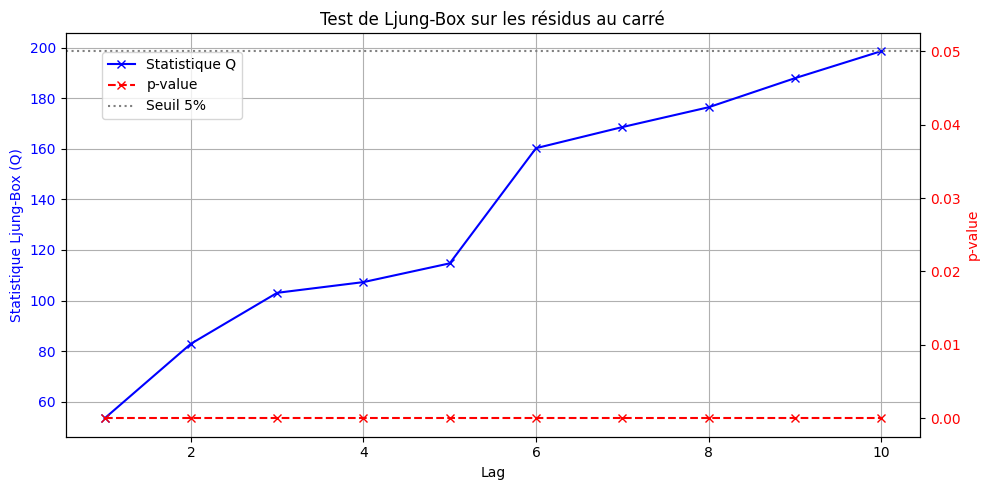

In [374]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
ljungbox = acorr_ljungbox(arimax_fit.resid**2, lags=range(1,11), return_df=True)

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'blue'
ax1.set_xlabel('Lag')
ax1.set_ylabel('Statistique Ljung-Box (Q)', color=color)
ax1.plot(ljungbox.index, ljungbox['lb_stat'], marker='x', color=color, label='Statistique Q')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('p-value', color=color)
ax2.plot(ljungbox.index, ljungbox['lb_pvalue'], marker='x', linestyle='--', color=color, label='p-value')
ax2.axhline(0.05, color='gray', linestyle=':', label='Seuil 5%')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Test de Ljung-Box sur les résidus au carré")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

**Constat :**   
Nous constatons que les p-values sont inférieures au seuil de 5%, ce qui conduit au rejet de l’hypothèse nulle H0 d’absence d’autocorrélation dans les résidus au carré. Cela indique une présence significative d’hétéroscédasticité conditionnelle.
La statistique Q augmente régulièrement avec le nombre de lags, ce qui traduit une accumulation de dépendance dans la variance résiduelle et suggère que la volatilité n’est pas entièrement captée par le modèle actuel.

**Raison :**    
Ce phénomène est économiquement cohérent, car la variance du taux EFFR n’est pas constante dans le temps. Le taux est fortement contraint par le Federal Funds Target Range (FFTR) :

- Il reste stable entre deux décisions de politique monétaire,

- Puis il s’ajuste brutalement (par paliers de 25, 50 ou 75 points de base) lors des hausses ou baisses de taux.    

Cette structure génère des phases de faible variance suivies de chocs ponctuels, caractéristiques de l’hétéroscédasticité.

**Solution :**  
Pour mieux modéliser cette dynamique, nous complétons notre modèle ARIMAX par un modèle de volatilité conditionnelle GARCH, appliqué aux résidus du modèle.
Ce couplage permet de capturer la structure de variance variable dans le temps et d’obtenir des intervalles de confiance dynamiques plus représentatifs du risque réel.

#### 3. Construction du modèle ARIMAX combiné au modèle GARCH

In [375]:
from arch import arch_model

# Modèle ARIMAX(p,d,q) sur les variables exogènes
arimax = ARIMA(
    endog=data['effr'], # Variable endogène
    exog=data[['Intercept', 'Slope', 'Curvature']], # Variables exogènes
    order=(2, 0, 0), # modèle ARIMA d'ordre (p, d, q)
    trend='n', # Ne pas ajouter de tendance
)
arimax_fit = arimax.fit()
print(arimax_fit.summary())

# Modèle GARCH(p,q) sur les résidus (vol='GARCH')
garch = arch_model(arimax_fit.resid, vol='GARCH', p=1, q=1, rescale=False)
garch_fit = garch.fit(disp='off')

print(garch_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   effr   No. Observations:                 1222
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 955.263
Date:                Fri, 11 Apr 2025   AIC                          -1898.526
Time:                        18:07:49   BIC                          -1867.876
Sample:                    08-05-2001   HQIC                         -1886.991
                         - 12-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     92.4978      1.281     72.208      0.000      89.987      95.008
Slope         61.6329      0.975     63.219      0.000      59.722      63.544
Curvature     18.8363      0.617     30.509      0.0

C:\Users\Matteo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


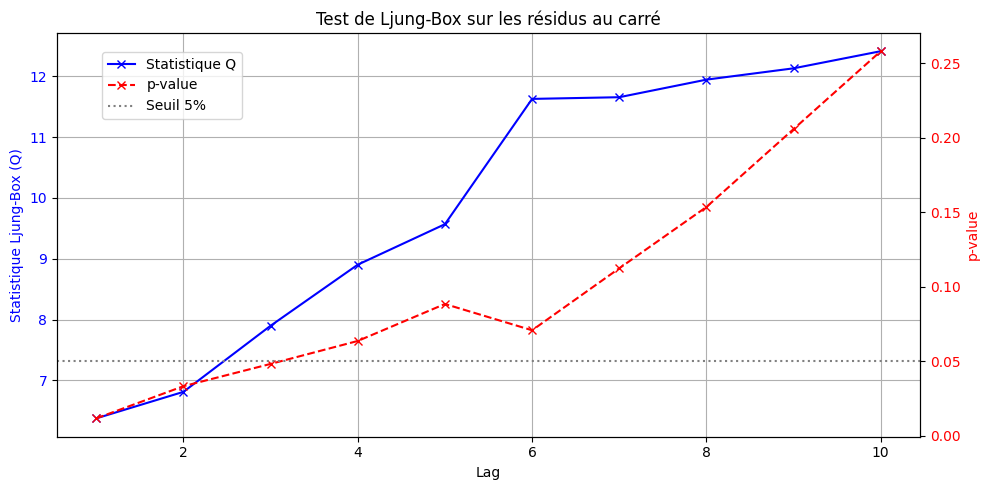

In [376]:
# Test sur les résidus au carré (détecte autocorrélation de la variance)
std_resid = garch_fit.std_resid
ljungbox = acorr_ljungbox(std_resid ** 2, lags=range(1,11), return_df=True)

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'blue'
ax1.set_xlabel('Lag')
ax1.set_ylabel('Statistique Ljung-Box (Q)', color=color)
ax1.plot(ljungbox.index, ljungbox['lb_stat'], marker='x', color=color, label='Statistique Q')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('p-value', color=color)
ax2.plot(ljungbox.index, ljungbox['lb_pvalue'], marker='x', linestyle='--', color=color, label='p-value')
ax2.axhline(0.05, color='gray', linestyle=':', label='Seuil 5%')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Test de Ljung-Box sur les résidus au carré")
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

**Constat :**   
Les p-values sont supérieures à 5% pour tous les lags, nous ne rejettons pas l’hypothèse nulle H0 d'absence d’autocorrélation dans les résidus au carré.
La statistique Q progresse avec les lags, mais reste dans une zone modérée. La courbe des p-values  reste au-dessus du seuil de 5%, ce qui confirme que les résidus ne présentent pas de dépendance significative dans leur variance

**Raison :**    
Cela indique que le modèle de volatilité GARCH appliqué capture correctement la structure d’hétéroscédasticité conditionnelle.
Les résidus du modèle sont devenus homoscédastiques, et donc statistiquement blancs du point de vue de la variance

**Conclusion :**    
Le modèle ARIMAX - GARCH est statistiquement bien spécifié : 
- Il n’y a plus de dépendance résiduelle dans la variance,
- Nous pouvons faire confiance aux prévisions d’incertitude (volatilité) générées par le modèle
Cela valide l’utilisation d’intervalles de confiance dynamiques pour la prédiction du taux EFFR

### Evolution de la variable endogène (EFFR) et de la volatilié conditionnelle des résidus (GARCH)

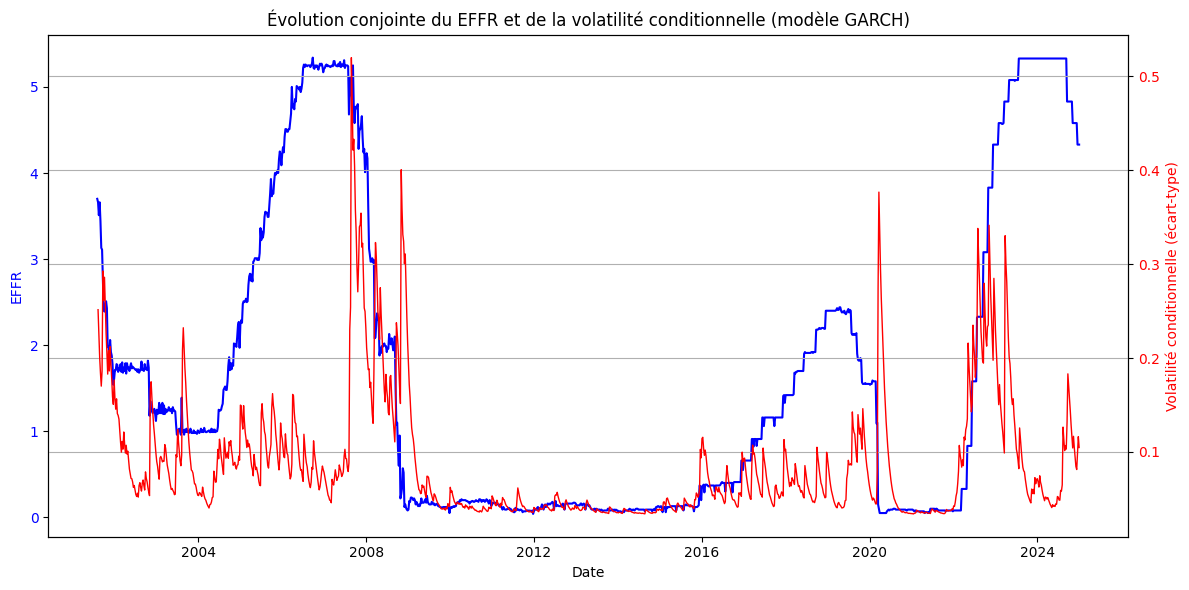

In [377]:
# Récupération des variances conditionnelles prévues par le modèle GARCH
cond_var = garch_fit.conditional_volatility  # écart-type conditionnel
vol_df = pd.Series(cond_var, index=effr.index[-len(cond_var):], name="Volatilité conditionnelle")

fig, ax1 = plt.subplots(figsize=(12, 6))
color1 = 'blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("EFFR", color=color1)
ax1.plot(data['effr'], color=color1, label='EFFR', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color1)
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel("Volatilité conditionnelle (écart-type)", color=color2)
ax2.plot(vol_df, color=color2, label='Volatilité conditionnelle (GARCH)', linewidth=1)
ax2.tick_params(axis='y', labelcolor=color2)
plt.title("Évolution conjointe du EFFR et de la volatilité conditionnelle (modèle GARCH)")
fig.tight_layout()
plt.grid(True)
plt.show()

Nous constatons des fluctuations marquées de l’écart-type conditionnel des résidus du modèle ARIMAX-GARCH. Plusieurs observations clés peuvent être formulées : 

1. Présence de régimes de volatilité bien distincts :
La série présente de longues périodes de faible volatilité, suivies de phases brèves mais intenses de hausse soudaine de la variance, ce qui est typique des séries financières ou monétaires soumises à des chocs structurels ou politiques.   

2. Pics de volatilité cohérents avec des épisodes économiques majeurs : 
    - Le pic extrême de 2008 coïncide avec la crise financière mondiale, confirmant la réactivité du modèle GARCH à des événements de marché majeurs.   
    - Une autre vague de volatilité apparaît autour de 2020, en lien probable avec les perturbations induites par la crise sanitaire du COVID-19 et les ajustements rapides du cadre de politique monétaire.    
    - Les pics observés en 2022–2023 reflètent les effets de la normalisation brutale des taux par la Réserve fédérale dans un contexte inflationniste post-pandémique. 
3. Retour progressif à un régime de basse volatilité après chaque choc :
Le modèle capture correctement la décroissance graduelle de l’incertitude après les phases de tension, traduisant une dynamique de mémoire longue de la variance conditionnelle, caractéristique des processus GARCH.   

### Applications du modèle ARIMAX-GARCH

In [378]:
from scipy.stats import norm

# Nombre de périodes à prédire
date = '2023-11-26'
X =data.loc[date, ['Intercept', 'Slope', 'Curvature']]
Y = data.loc[date,'effr']

# Prévision de la volatilité avec le modèle ARIMAX
arimax_forecast = arimax_fit.get_forecast(steps=1, exog=X)
forecast_mean = arimax_forecast.predicted_mean.iloc[0]

confidence = 0.95 # Niveau de confiance
z = norm.ppf(1 - (1 - confidence) / 2)

# Prévision de la variance avec le modèle GARCH
garch_forecast = garch_fit.forecast(horizon=1)
forecast_variance = garch_forecast.variance.iloc[-1, 0]
forecast_std = forecast_variance**0.5

# Calculer l'intervalle de confiance
lower_bound = forecast_mean - z * forecast_std
upper_bound = forecast_mean + z * forecast_std

print(f'Date: {date}')
print(f'EFFR Constaté: {Y}')
print("Prévision EFFR:")
print("Prévision EFFR :", round(forecast_mean, 2))
print(f"Intervalle à 95% : [{round(lower_bound, 2)} ; {round(upper_bound, 2)}]")

Date: 2023-11-26
EFFR Constaté: 5.33
Prévision EFFR:
Prévision EFFR : 5.31
Intervalle à 95% : [5.13 ; 5.5]


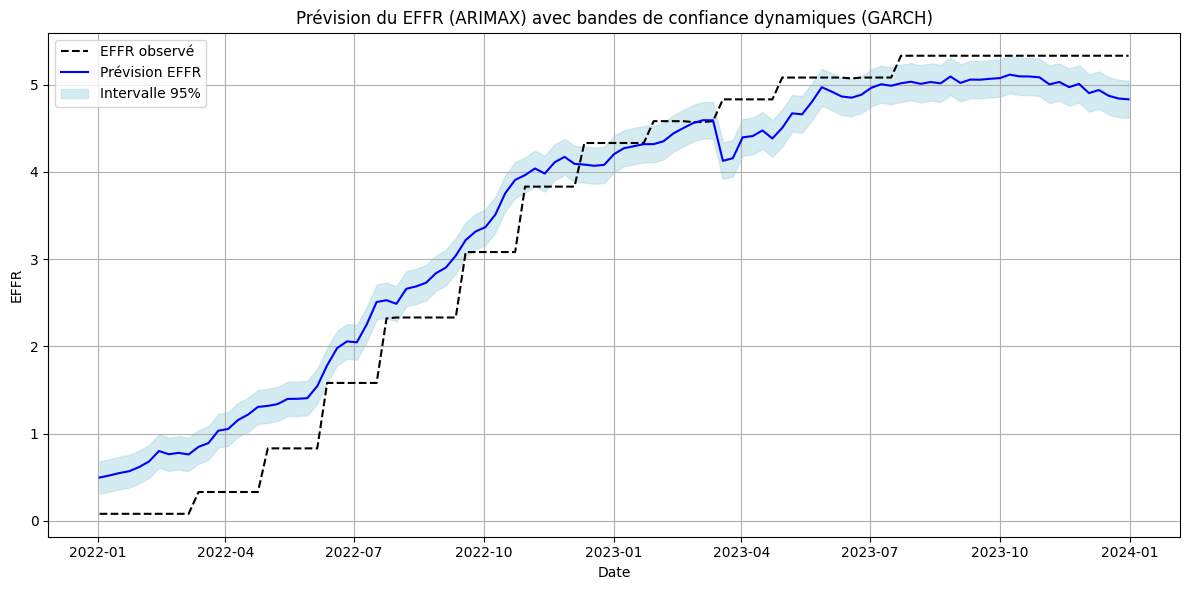

In [379]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Fenêtre de prévision
start = '2022'
end = '2023'
X = data.loc[start:end, ['Intercept', 'Slope', 'Curvature']]
Y = data.loc[start:end, 'effr']
horizon = len(X)

# Prévision moyenne (ARIMAX)
arimax_forecast = arimax_fit.forecast(steps=horizon, exog=X)

# Prévision de la volatilité conditionnelle (GARCH)
garch_forecast = garch_fit.forecast(horizon=horizon)
forecast_var = garch_forecast.variance.iloc[-1].values
forecast_std = forecast_var ** 0.5

# Calcul de l'intervalle de confiance
confidence = 0.95
z = norm.ppf(1 - (1 - confidence) / 2)
lower_bound = arimax_forecast - z * forecast_std
upper_bound = arimax_forecast + z * forecast_std

forecast_index = X.index
plt.figure(figsize=(12, 6))
plt.plot(Y.index, Y, label='EFFR observé', color='black', linestyle='--')
plt.plot(forecast_index, arimax_forecast, label='Prévision EFFR', color='blue')
label = f'Intervalle {int(confidence*100)}%'
plt.fill_between(forecast_index, lower_bound, upper_bound, color='lightblue', alpha=0.5, label=label)
plt.title('Prévision du EFFR (ARIMAX) avec bandes de confiance dynamiques (GARCH)')
plt.xlabel('Date')
plt.ylabel('EFFR')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()